If not yet available some libraries and their python bindings have to be installed :<br>
- gmsh (best installed globally through package management system)
- python3 -m pip install pygmsh --user
- VTK (best installed globally through package management system)
- python3 -m pip install vtk --user

In [1]:
import numpy as np
from scipy import constants
import gmsh
from MeshedFields import *

# Create a meshed screen with a central hole

In [2]:
Ra = 0.030
Ri = 0.002
lca = 0.005
lci = 0.0005
stretch = 5.0

In [3]:
gmsh.initialize()
gmsh.clear()

# outer points
gmsh.model.geo.addPoint(Ra*stretch, 0.0, 0.0, lca, 1)
gmsh.model.geo.addPoint(0.0, Ra, 0.0, lca, 2)
gmsh.model.geo.addPoint(-Ra*stretch, 0.0, 0.0, lca, 3)
gmsh.model.geo.addPoint(0.0, -Ra, 0.0, lca, 4)
# inner points
gmsh.model.geo.addPoint(Ri*stretch, 0.0, 0.0, lci, 5)
gmsh.model.geo.addPoint(0.0, Ri, 0.0, lci, 6)
gmsh.model.geo.addPoint(-Ri*stretch, 0.0, 0.0, lci, 7)
gmsh.model.geo.addPoint(0.0, -Ri, 0.0, lci, 8)
# center point
gmsh.model.geo.addPoint(0, 0, 0, lci, 9)

# elliptic arcs (start, center, major, end)
gmsh.model.geo.add_ellipse_arc(1,9,1,2, tag=10)
gmsh.model.geo.add_ellipse_arc(2,9,1,3, tag=20)
gmsh.model.geo.add_ellipse_arc(3,9,1,4, tag=30)
gmsh.model.geo.add_ellipse_arc(4,9,1,1, tag=40)
gmsh.model.geo.add_ellipse_arc(5,9,5,6, tag=50)
gmsh.model.geo.add_ellipse_arc(6,9,5,7, tag=60)
gmsh.model.geo.add_ellipse_arc(7,9,5,8, tag=70)
gmsh.model.geo.add_ellipse_arc(8,9,5,5, tag=80)

# outer curve loop
gmsh.model.geo.addCurveLoop([10, 20, 30, 40], 11)
# inner curve loop
gmsh.model.geo.addCurveLoop([50, 60, 70, 80], 12)

# square (plate) surface
s = gmsh.model.geo.addPlaneSurface([11,12])

# synchronize
gmsh.model.geo.synchronize()

# generate mesh
gmsh.model.mesh.generate(dim=2)

# display mesh
# gmsh.fltk.run()

In [4]:
# the mesh points are given as a list of tags (reference numbers)
# and a list of coordinates
# triangles reference the tags of the corner points
ptTags, coord, _ = gmsh.model.mesh.get_nodes(dim=2, includeBoundary=True, returnParametricCoord=False)
N_pts = ptTags.shape[0]
print(N_pts)
pts = coord.reshape((N_pts,3))
print(pts.shape)
print(ptTags.min(), ptTags.max())

1634
(1634, 3)
1 1635


In [5]:
elementTags, nodeTags = gmsh.model.mesh.getElementsByType(2)
N_tri = elementTags.shape[0]
print(N_tri)
# change references from node tags to indices in the list of points
ind = np.array([np.where(ptTags==nt)[0] for nt in nodeTags])
print(ind.min(), ind.max())
tris = ind.reshape((N_tri,3))
print(tris.shape)
print(tris.min(), tris.max())

3052
0 1633
(3052, 3)
0 1633


In [6]:
gmsh.finalize()

In [10]:
# we squeeze the ellipse back to a circle
# angle it
# and move the screen to its intended position
d = np.array([0.0,0.0,1.0])
points = np.array([np.array([p[0]/stretch,p[1],p[0]/stretch])+d for p in pts])
screen = MeshedField(points,tris)

The screen is placed at z=1m from th origin. A beam is assumed to propagate in z direction<br>
The fields shall be reflected to th x direction. The screen normal is pointing in the negative z and positive x direction (x - left, y - up).

In [11]:
print("%d points" % len(screen.points))
print("%d triangles" % len(screen.triangles))
area = screen.MeshArea()
normals = screen.MeshNormals()
average = np.sum(normals, axis=0)/screen.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)
screen.ShowMeshedField(showAxes=True)

1634 points
3052 triangles
total mesh area =  39.773 cm²
screen normal = [ 7.07106781e-01 -1.78469156e-16 -7.07106781e-01]


In [12]:
screen.ShowMeshedField()

### define the timing
The beam is assumed to start at t=0. The fields are propagating with c so the expected time a
signal arrives at some screen point is z/c.

In [13]:
# time step
screen.dt = 1.0e-13
# all points use the same timing grid
screen.Nt = 400
screen.t0 = np.array([p[2]/constants.c-screen.Nt/2*screen.dt for p in screen.pos])

### Write the file
It is assumed that the script was started from the scripts directory. The file should be created in the tests folder.

In [14]:
filename="../tests/DiffractionScreen.h5"
screen.WriteMeshedField(filename)

not writing ElMagField dataset


### Check the file after running the test

In [16]:
filename = "../tests/DiffractionScreenWithFields.h5"
computed = MeshedField.ReadMeshedField(filename)

print("%d points" % len(computed.points))
print("%d triangles" % len(computed.triangles))
area = computed.MeshArea()
normals = computed.MeshNormals()
average = np.sum(normals, axis=0)/computed.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)

corner points :  (1634, 3)
triangles :  (3052, 3)
Nt = 400   dt = 1e-13 
t0 :  (3052,)
field :  (3052, 400, 6)
1634 points
3052 triangles
total mesh area =  39.773 cm²
screen normal = [ 7.07106781e-01 -1.78469156e-16 -7.07106781e-01]


In [17]:
projected_area = np.sum(area) / np.sqrt(2)
print("projected mesh area = %7.3f cm²" % (1.0e4*projected_area))
projected_radius = np.sqrt(projected_area/np.pi)
print("projected radius = %7.3f cm" % (1.0e2*projected_radius))

projected mesh area =  28.124 cm²
projected radius =   2.992 cm


In [18]:
area = computed.MeshArea()
S = [np.linalg.norm(computed.EnergyFlowVector(i)) for i in range(computed.Np)]
Pz = [computed.NormalEnergyFlow(i) for i in range(computed.Np)]

print("peak energy density = %.6f J/m²" % np.max(S))
print("total pulse energy = %.3f µJ" % (1e6*np.dot(area,Pz)))

peak energy density = 0.020276 J/m²
total pulse energy = 0.491 µJ


cell No. 2447 pos=[9.34138686e-05 2.28985534e-03 1.00009341e+00]
pointing vector S=[7.10531778e-09 1.74172744e-07 1.39290521e-02]


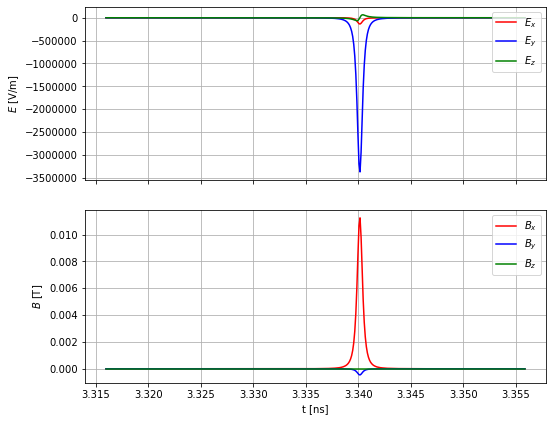

cell No. 839 pos=[0.0051755  0.02661737 1.0051755 ]
pointing vector S=[-8.02076068e-11 -4.12503983e-10  8.44925275e-06]


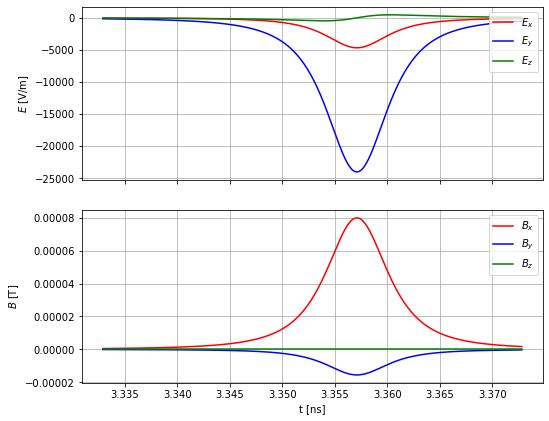

cell No. 2956 pos=[-0.02794564 -0.00357545  0.97205436]
pointing vector S=[4.08135143e-10 5.22180722e-11 7.53266496e-06]


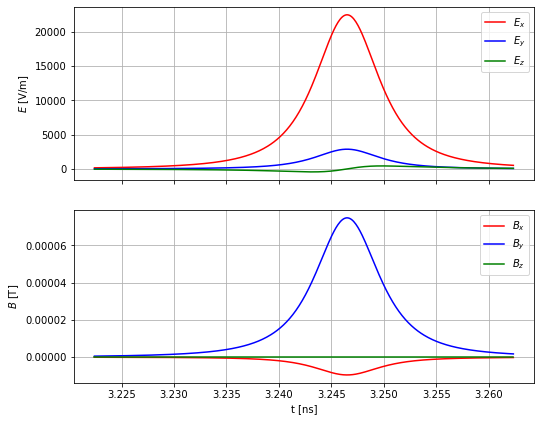

cell No. 356 pos=[ 0.02913313 -0.0022595   1.02913313]
pointing vector S=[-4.53920140e-10  3.52050717e-11  6.75088736e-06]


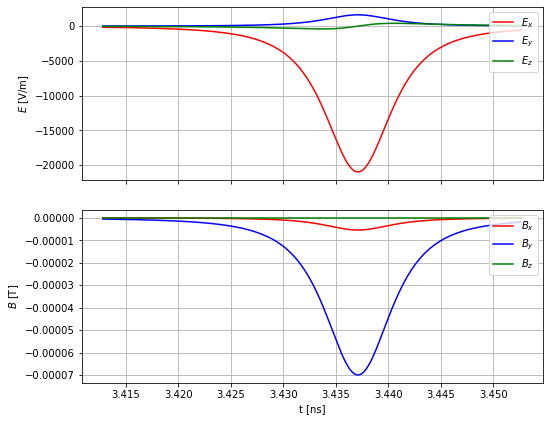

cell No. 1775 pos=[ 0.00631871 -0.02814893  1.00631871]
pointing vector S=[-9.59109443e-11  4.27269541e-10  7.01509368e-06]


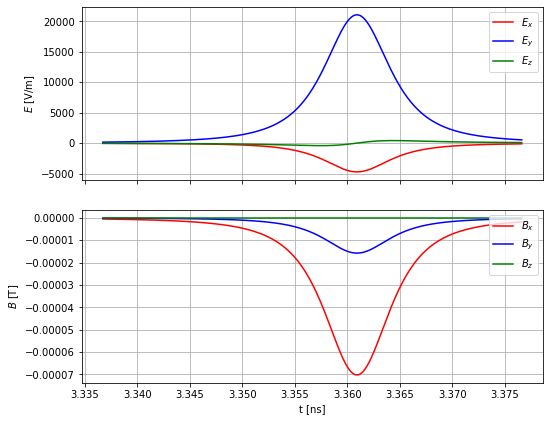

In [21]:
def pick(id):
    if id>0 and id<computed.Np:
        print("cell No. %d pos=%s" % (id,computed.pos[id]))
        print("pointing vector S=%s" % computed.EnergyFlowVector(id))
        computed.ShowFieldTrace(id)

computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)

In [21]:
t = 3.34e-9
fields = computed.FieldsAtTime(t)
Ex = [f[0] for f in fields]
Ey = [f[1] for f in fields]
computed.ShowMeshedField(scalars=Ey,scalarTitle="Ey",showGrid=False,lut=phaseLUT())